## Reading the data

In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


df = pd.read_csv("../../corpus_sprint3_balanced_cleaned_all.csv", encoding="utf-8")
df = df.dropna()
print(df)
print(df.shape)

model = Doc2Vec.load("../../model_doc2vec_balanced_20epochs")

                                                Product  \
0             Payday loan, title loan, or personal loan   
1             Payday loan, title loan, or personal loan   
2                                 Vehicle loan or lease   
3     Money transfer, virtual currency, or money ser...   
4             Payday loan, title loan, or personal loan   
...                                                 ...   
9405                        Checking or savings account   
9406                            Bank account or service   
9407                            Bank account or service   
9408                            Bank account or service   
9409                            Bank account or service   

                           Consumer complaint narrative  
0     they would not let me pay my loan off 2 days b...  
1     service finance are liars and are charging me ...  
2     on xx/xx/ i signed a car loan agreement to fin...  
3     we hired and debt collection to handle collect...  
4

## One hot encoding and concatenating

In [2]:
vectors = model.docvecs.vectors_docs

In [3]:

one_hot = pd.Categorical(df['Product'])
df_dummies = pd.get_dummies(one_hot)

v_df = pd.DataFrame(vectors)
df_concat = pd.concat([v_df, df_dummies], axis = 1)
print(df_concat.shape)

(9410, 63)


## Applying T-SNE

In [4]:
tsne = TSNE(n_components=2)
data_reduced = tsne.fit_transform(df_concat)


In [5]:
print(data_reduced.shape)

(9410, 2)


## Applying k-means

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


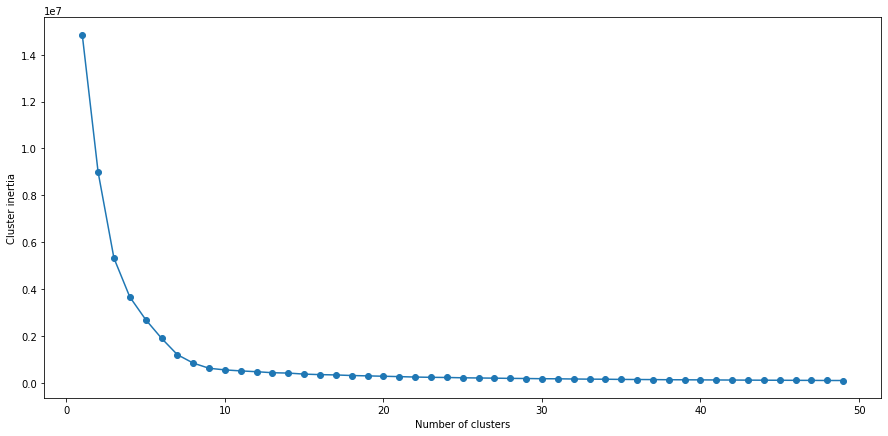

In [7]:
inertia = []
k_min=1
k_max=50
for i in range(k_min, k_max):
    print(i)
    km = KMeans(n_clusters=i,init='k-means++')
    km.fit(data_reduced)
    inertia.append(km.inertia_)
plt.rcParams['figure.figsize'] = [15,7]
plt.plot(range(k_min,k_max), inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cluster inertia')
plt.show()

## Silhouette scores

For n_clusters = 7 The average silhouette_score is : 0.6110775
For n_clusters = 8 The average silhouette_score is : 0.6511916
For n_clusters = 9 The average silhouette_score is : 0.6794443
For n_clusters = 10 The average silhouette_score is : 0.6316054
For n_clusters = 11 The average silhouette_score is : 0.6383477
For n_clusters = 12 The average silhouette_score is : 0.54769933
For n_clusters = 13 The average silhouette_score is : 0.61460227


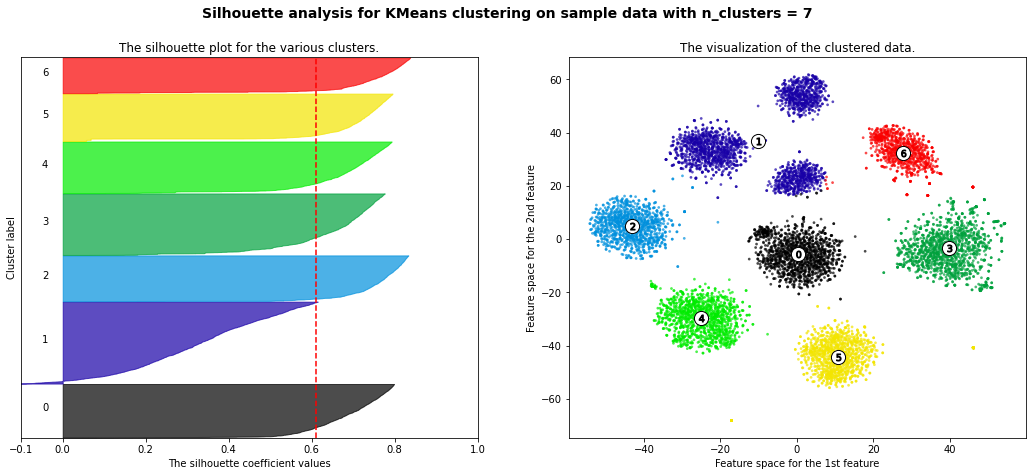

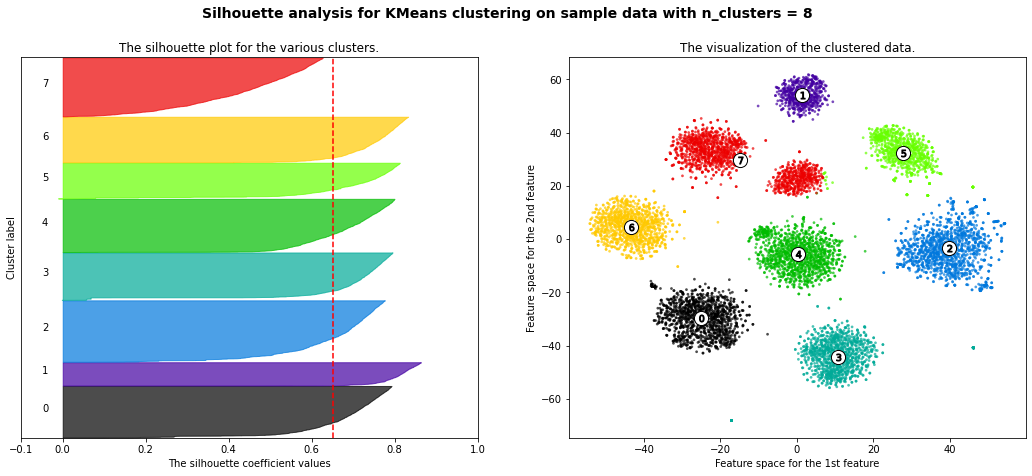

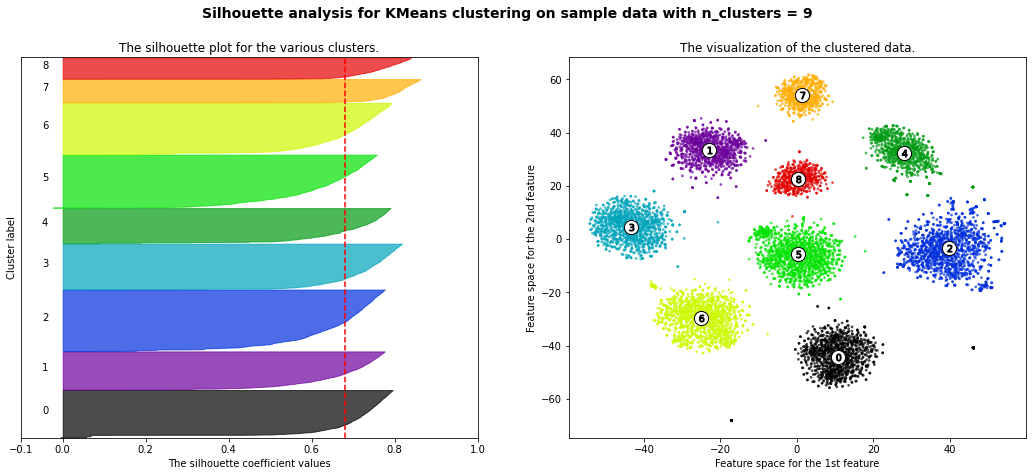

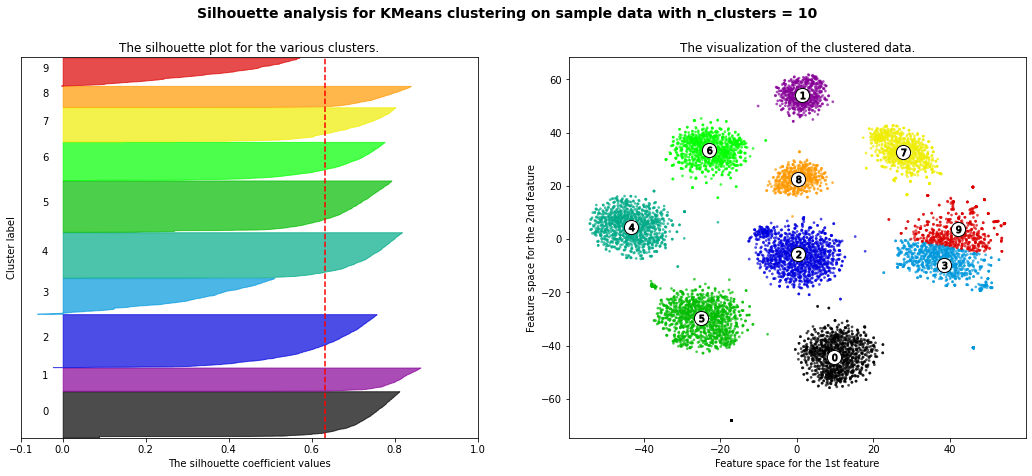

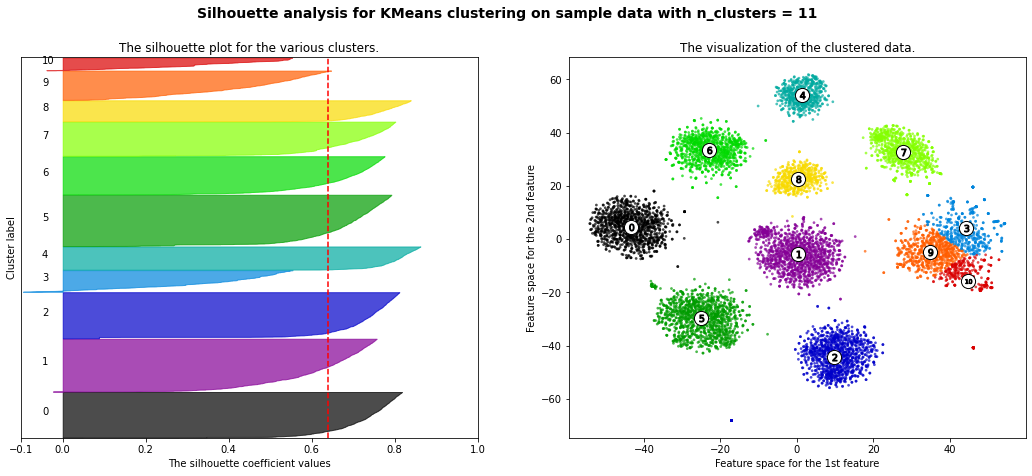

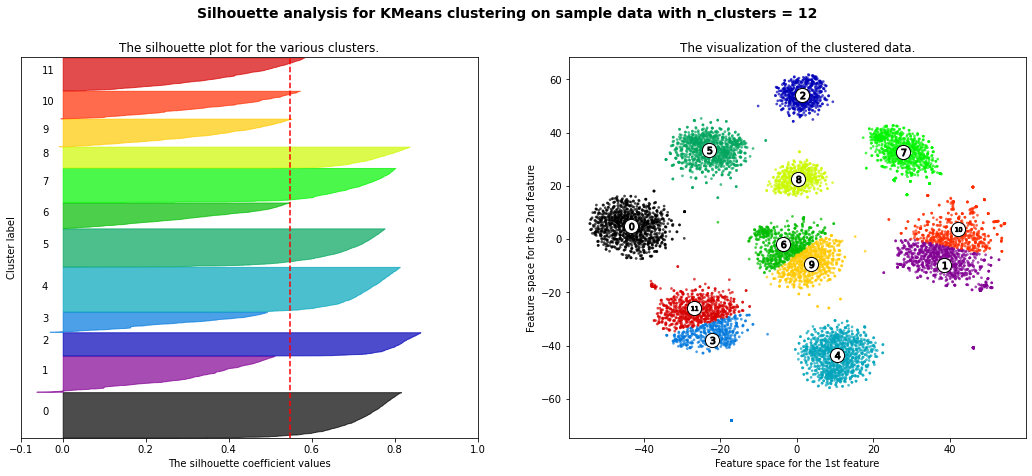

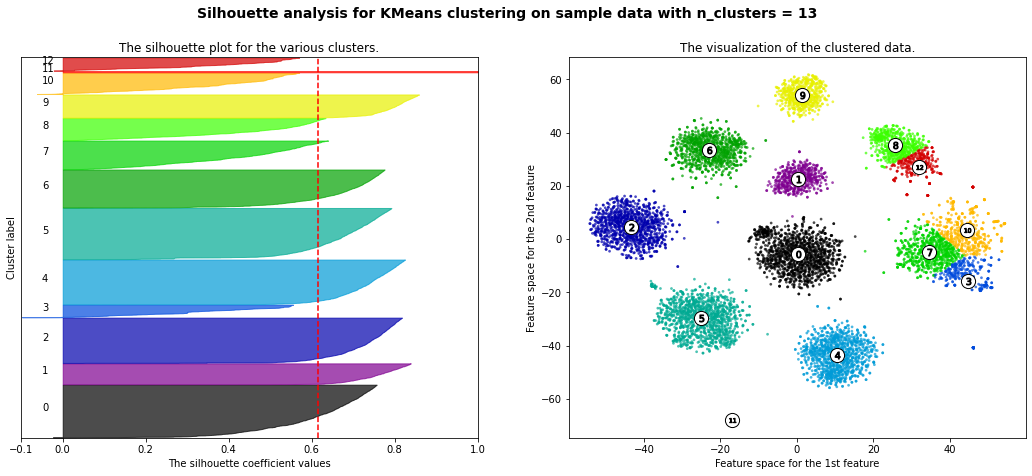

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

for n_clusters in range(7,14):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_reduced) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_reduced, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_reduced, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


## Analyzing with narrative

In [8]:
number_clusters = 9
km = KMeans(n_clusters=number_clusters,init='k-means++')
indexes = km.fit_predict(data_reduced)
centroids = km.cluster_centers_

#v_df = pd.DataFrame(vectors)
df_result = pd.concat([df, pd.DataFrame(indexes)], axis = 1)
print(df_result)

                                                Product  \
0             Payday loan, title loan, or personal loan   
1             Payday loan, title loan, or personal loan   
2                                 Vehicle loan or lease   
3     Money transfer, virtual currency, or money ser...   
4             Payday loan, title loan, or personal loan   
...                                                 ...   
9405                        Checking or savings account   
9406                            Bank account or service   
9407                            Bank account or service   
9408                            Bank account or service   
9409                            Bank account or service   

                           Consumer complaint narrative  0  
0     they would not let me pay my loan off 2 days b...  3  
1     service finance are liars and are charging me ...  3  
2     on xx/xx/ i signed a car loan agreement to fin...  1  
3     we hired and debt collection to handle co

Cluster number: 0
i do not owe this debt i request all of the following information be provided to me documentation showing you have verified that i am responsible for this debt or a copy of my signature with a signed contract with this company. otherwise i ask that you remove this debt from my credit file as it is reflecting negative on my file and is making my file look bad.

 i received a letter from key recovery stating that i owed 6500.00 to . i emailed key recovery on  to find out more information and never had a response. i contacted who stated and provided proof that my balance is only 4400.00 with them. key recovery is charging me 2100.00 in fee s.

this is address . i have sent several requests for proper debt validation to convergent outsourcing wa . i have not received it proper debt validation. they keep sending me information which is not relevant. this company received and signed for the letters i sent them. they are continuing to report this account in my name constitut

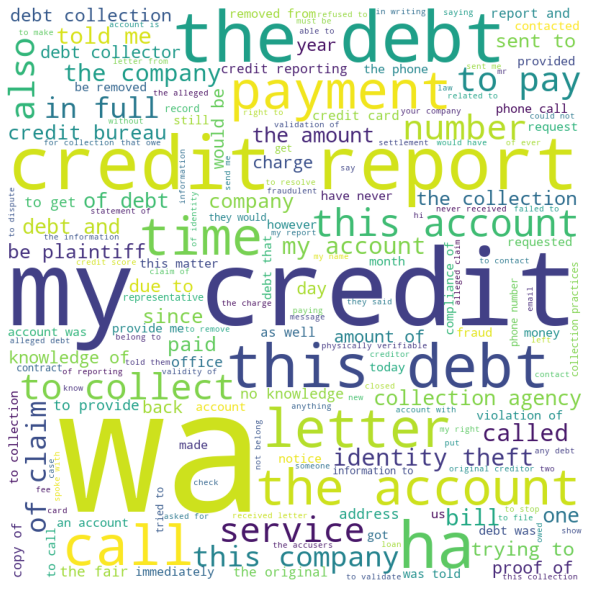

Cluster number: 1
my information was used to obtain a loan from chase bank. i have mailed in documentation to the financial institution denial of financial responsibility forms signed by a notary. the companies have not stopped harassing me and they want me to pay for something associated with fraud. i have requested a contract with a signature that belongs to me and they have yet to produce one whatsoever. i have mailed to them proof that the debt and loan does not belong to me and they have not produced any validation of any agreement that verifies i have any loan or promise to pay chase auto or any financial responsibility.

loan paid off in . we still do not have the title. the company can not locate the title nor tell us how to get a replacement title. they will not return our calls and either hang up on us or just put us on hold. we have been to the dmv here in florida. we have contacted the california state where the loan originated and our residence at the time of origination d

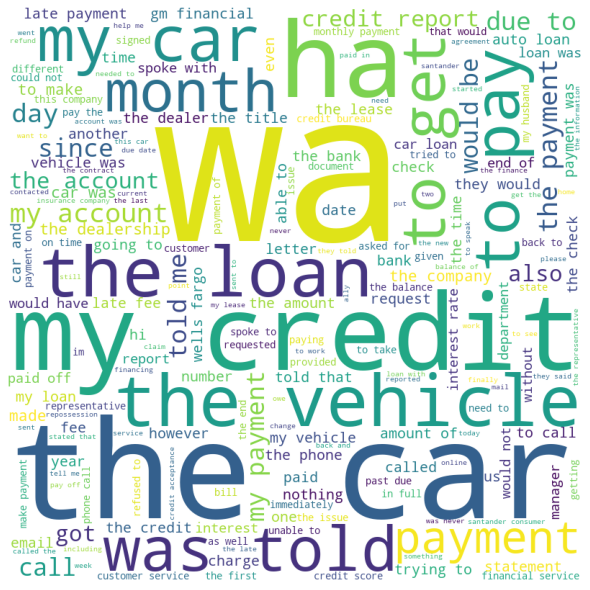

Cluster number: 2
good afternoon i am complaining on the actions taken by nfcu on xx/xx/ in which they permanently closing my account due the suspicion of fraud. i had a friend wired me money from his bank in the amount of 9600.00 to my credit card it was on hold for 7 - 10 days to be process but it didn t process at all after several attempts. nfcu representatives declined to assist me in resolving the issue.

before xx/xx/ i opened what i understood to be a rolling cd account with chase then . i had forgotten about the account for years after became chase. prior to xx/xx/ the account popped up on my chase dashboard with very limited information. i had not received statements on the account for years despite my address being updated on my accounts at that point so i wasn t sure what it was or why chase was saying i had a traditional ira account with them. in xx/xx/i was asked to add a beneficiary to the account i have to note i wasn t paying much attention to this account and hadn t r

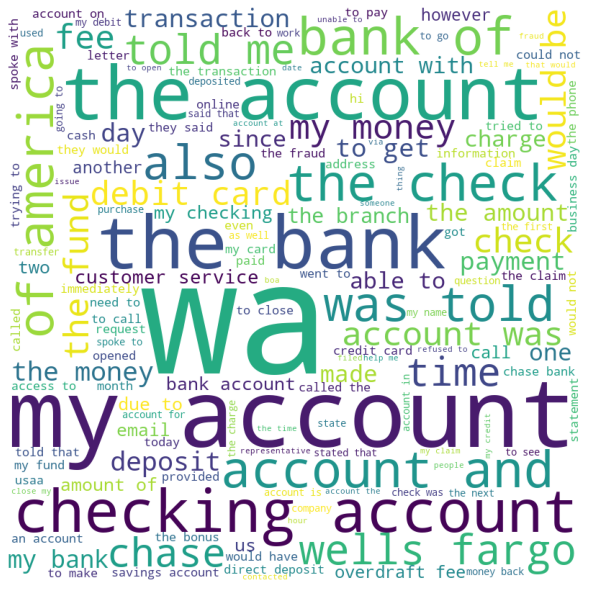

Cluster number: 3
to whom this may concern on or about  i called american first finance and request all auto debits be stopped as i had fraud on my account and needed to close the account. on or about  american first finance attempted to debit a payment causing nsf charge as well as believed my account was still opened and active delaying the time it took to close the account. on  i called american first to request i letter stated that i had previously requested the auto debits to stop. at that time the customer service rep denied the request suggesting an account credit to which i denied. i then request a manager since i was only asking for a letter. the manager also denied the request. at that time i requested the manger to set a time to retrieve the security interest as stated in sec 8 and 11 4 on my signed contract to which the manager rejected the request. as such this absolve me of any liability

we agreed on a payment amount and they started increasing the amount due outrageousl

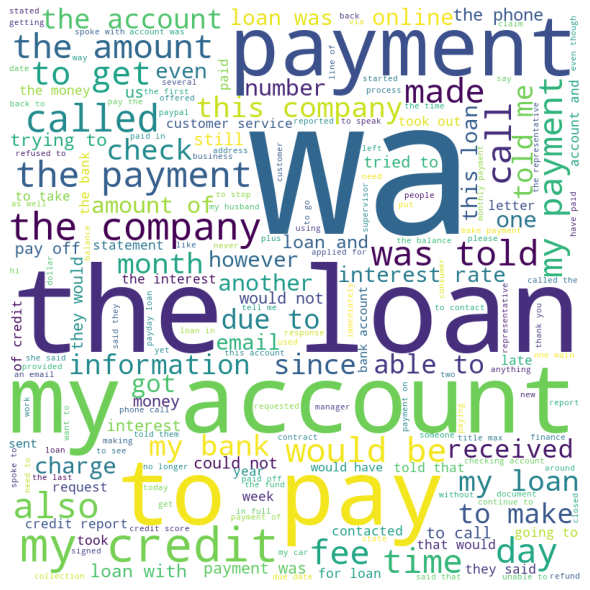

Cluster number: 4
on  i purchased tickets for 400.00 and was requested to pay via . this is a transaction that occurs over the phone and paid it to a phone number via the . i sent the money and then the person never emailed the tickets as promised. i tried to contact the person by phone and i was blocked. i also tried calling via another number and also then blocked. immediately after realizing i had been defrauded i contacted customer service and alerted them to the issue and requested they hold the funds. i then contacted my citibank credit card company and immediately disputed the charge. at this point in time they have stated that they only temporarily credited my account. the merchant responded and will favor with them with no regard for items not received even though they were both aware that this was a fraudulent transaction.

on xx/xx/ i called credit card customer services regarding 2 fraudulent charges to my card made at the store home depot on xx/xx/ one for 520.00 in fl at 

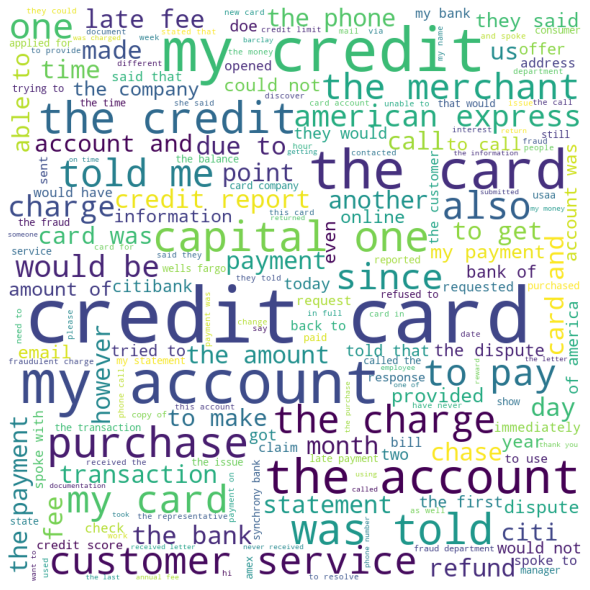

Cluster number: 5
our company s email account was hacked in . the hacker sent emails to our customer stating that our bank account number had changed. our customer issued due payments against our invoices i.e. 83000.00 & 11000.00 to the fraud account by electronic funds transfer unknowing that these payments were issued to a fraud account. the fraud account was also an account with our bank i.e. wells fargo bank n.a. wells fargo bank n.a. accepted the electronic funds transfer despite a complete disconnect between the beneficiary name and beneficiary account number. as the fraud account as well as our company s accounts are well fargo bank n.a. accounts wells fargo bank n.a. knew that no person had rights as a beneficiary and acceptance of the subject electronic funds transfers can not occur. i have included herewith email correspondence along with corresponding document exchanges with wells fargo bank n.a. requesting feedback on this error on their part. they are standing firm that be

on  i was in contact with a person named " via text message from phone number about concert meet and greet ticket for in ma. stated that she would sell me two meet and greet tickets for 40.00 a piece totaling 80.00 . asked me to send the money through friends and family so that she did not have to pay the fee and wait for the money to come through. i sent the money to her and then she stated that she cancelled it accidentally. i asked her for proof it was cancelled in which she supplied me with a transaction number from . i resent money again to her and she stated that she received it. i asked for proof of the tickets and who she was and she sent it to me also. i never received the product i paid for. i contacted and they stated they could not do anything for me due to me sending it friends and family and not business transaction. i then disputed the transaction through bank of america due to that being the credit card i used. bank of america stated that they could not do anything for 

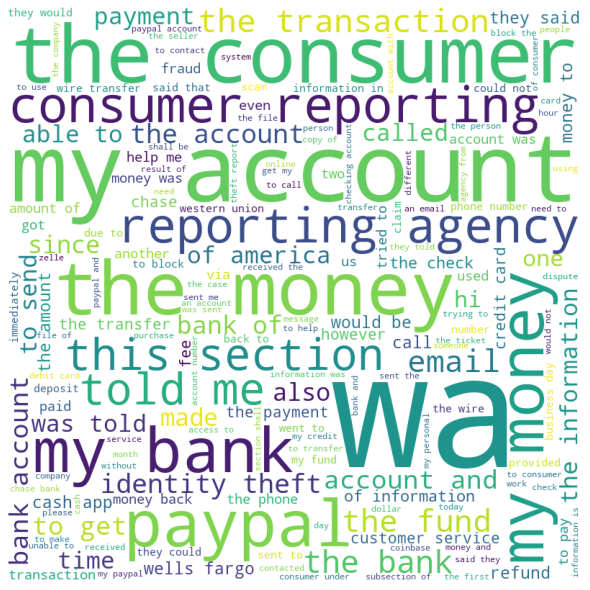

Cluster number: 6
my account with which was opened in and closed in xx/xx/ and 100 paid off keeps reappearing on my credit report even though they take it off and then put it back on.

i was going over my credit report fraudulent accounts and i seen unauthorized accounts that i do not recognize. fcra 605b 15 u.s.c. 1681c-2 a block. except as otherwise provided in this section a consumer reporting agency shall block the reporting of any information in the file of a consumer that the consumer identifies as information that resulted from an alleged identity theft not later than 4 business days after the date of receipt by such agency. demand to see the application for credit or request for business. i demand see the purpose and written contract and proof that i applied for these accounts i am a victim of fraud and i am protecting my credit file as much as i can.

credit bureaus put stuff on my credit report without even warning me about it. i never received any correspondence from them.. 

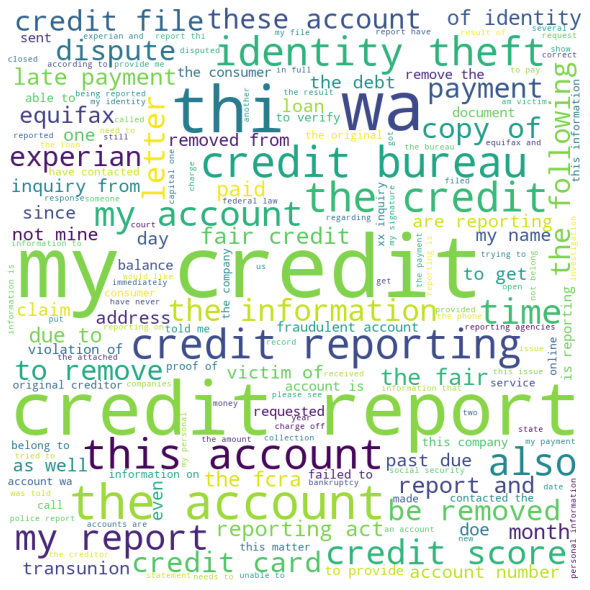

Cluster number: 7
i have applied for pslf program with fedloan.org since . majority of my payments that were made between are considered unqualified and are not being counted towards pslf payments. payments that were made between were more than i would have paid under qualified plan for pslf. i know classmates that are doing pslf program that have paid 0.00 and payments of 0.00 is considered and counted as qualified payments while my 990.00 payments are not qualified payments. where is the justice 

i re-applied for income driven repayment icr in early with my wife who also has a similar amount of student loan debt. we are both and both went to . she received her icr re-calculation a few days later and it was what we were anticipating it would be and more importantly it was something we knew we could afford. when i received mine it was double the amount of hers and way out of the range of what we were anticipating or budgeting for. she guessed it was because they forgot to include her 

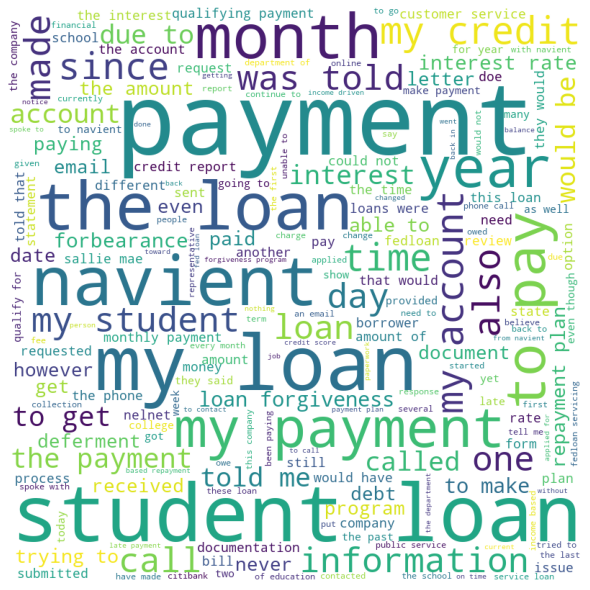

Cluster number: 8
Number of entries: 525


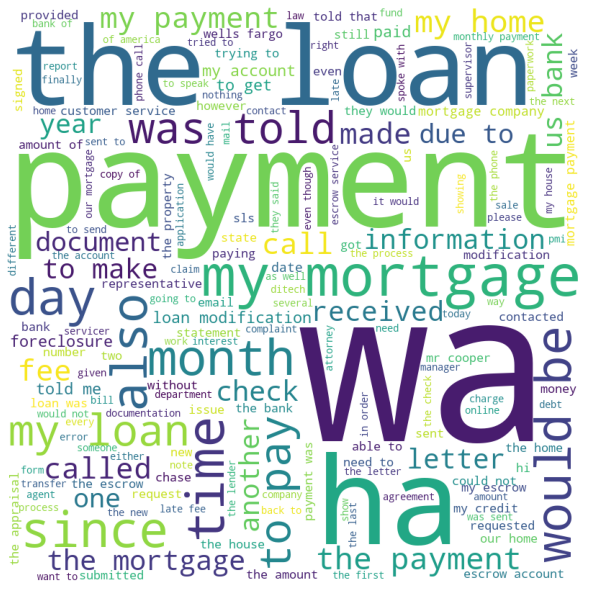

In [9]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import random

#if it's your first time running with these stopwords, run the following line aswell:
#nltk.download('stopwords')

stopwords = set(stopwords.words('english'))
stopwords.add('xx')

for i in range(0,number_clusters):
    all_words = ''
    print('Cluster number: '+str(i))
    amount = 0
    for index, row in df_result.iterrows():
        if row[0] == i:
            all_words += ' ' + row['Consumer complaint narrative']
            rand = random.randint(1,200)
            amount += 1
            if(rand == 1):
                print(row['Consumer complaint narrative'] + '\n')
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(all_words) 
    print('Number of entries: ' + str(amount))
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 
